![title](pics/March_Madness_logo.svg)

## 1. Data retrieval

### 1.1. Importing modules

In [1]:
import numpy as np
import pandas as pd


from bokeh.plotting import figure, show,output_notebook, ColumnDataSource
from bokeh.layouts import row

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb

import drawing

sns.set_style("whitegrid")
output_notebook() 
DIR = '../2020-NCAAW-data'

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading BokehJS ...

In [2]:
drawing

<module 'drawing' from 'Z:\\Kaggle\\Google-Cloud-NCAA-ML-Competition-2020-NCAAW\\drawing.py'>

### 1.2. Data section 1 - The Basics

**Stage 1** - You should submit predicted probabilities for every possible matchup in the past 5 NCAA® tournaments (seasons 2015-2019).

**Stage 2** - You should submit predicted probabilities for every possible matchup before the 2020 tournament begins.


*    **ID** - this is a 14-character string of the format SSSS_XXXX_YYYY, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team.
*    **Pred** - this contains the predicted winning percentage for the first team identified in the ID field, the one represented above by XXXX.


In [3]:
sample_submission = pd.read_csv('{}/WSampleSubmissionStage1_2020.csv'.format(DIR))
sample_submission

,ID,Pred
0,2015_3106_3107,0.5
1,2015_3106_3110,0.5
2,2015_3106_3113,0.5
3,2015_3106_3114,0.5
4,2015_3106_3116,0.5
...,...,...
10075,2019_3413_3417,0.5
10076,2019_3413_3460,0.5
10077,2019_3416_3417,0.5
10078,2019_3416_3460,0.5


### 1.2.1. Teams


* **TeamID** - a 4 digit id number, from 3000-3999, uniquely identifying each NCAA® women's team. A school's TeamID does not change from one year to the next, so for instance the Duke women's TeamID is 3181 for all seasons. To avoid possible confusion between the men's data and the women's data, all of the men's team ID's range from 1000-1999, whereas all of the women's team ID's range from 3000-3999. 

* **TeamName** - a compact spelling of the team's college name, 16 characters or fewer. There are no commas or double-quotes in the team names, but you will see some characters that are not letters or spaces, e.g., Texas A&M, St Mary's CA, TAM C. Christi, and Bethune-Cookman. Also note that several teams have had their team names changed slightly since last year: "Albany NY" is now "SUNY Albany", "Santa Barbara" is now "UC Santa Barbara", "VA Commonwealth" is now "VCU", "Edwardsville" is now "SIUE", "Cal Poly SLO" is now "Cal Poly", "IPFW" is now "PFW", "Long Island" is now "LIU Brooklyn", and "ULL" is now "Louisiana".



In [4]:
teams = pd.read_csv('{}//WDataFiles_Stage1/WTeams.csv'.format(DIR))
teams

,TeamID,TeamName
0,3101,Abilene Chr
1,3102,Air Force
2,3103,Akron
3,3104,Alabama
4,3105,Alabama A&M
...,...,...
360,3463,Yale
361,3464,Youngstown St
362,3465,Cal Baptist
363,3466,North Alabama


### 1.2.2. Seasons


*    **Season** - indicates the year in which the tournament was played. Remember that the current season counts as 2020.
*    **DayZero** - tells you the date corresponding to DayNum=0 during that season. All game dates have been aligned upon a common scale so that (each year) Selection Monday is on day 133. All game data includes the day number in order to make it easier to perform date calculations. If you need to know the exact date a game was played on, you can combine the game's "DayNum" with the season's "DayZero". For instance, since day zero during the 2011-2012 season was 10/31/2011, if we know that the earliest regular season games that year were played on DayNum=7, they were therefore played on 11/07/2011.
*    **RegionW, RegionX, Region Y, Region Z** - by convention, the four regions in the final tournament are always named W, X, Y, and Z. Whichever region's name comes first alphabetically, that region will be Region W. And whichever Region plays against Region W in the national semifinals, that will be Region X. For the other two regions, whichever region's name comes first alphabetically, that region will be Region Y, and the other will be Region Z. This allows us to identify the regions and brackets in a standardized way in other files. For instance, during the 2012 tournament, the four regions were DesMoines, Fresno, Kingston, and Raleigh. Being the first alphabetically, DesMoines becomes W. Since the Fresno regional champion (Stanford) played against the DesMoines regional champion (Baylor) in the national semifinals, that makes Fresno be region X. For the other two (Kingston and Raleigh), since Kingston comes first alphabetically, that makes Kingston Y and therefore Raleigh is Z. So for that season, the W/X/Y/Z are DesMoines,Fresno,Kingston,Raleigh. And so for instance, Baylor, the #1 seed in the DesMoines region, is listed in the WNCAATourneySeeds file with a seed of W01, meaning they were the #1 seed in the W region (the DesMoines region). We will not know the final W/X/Y/Z designations until Selection Monday, because the national semifinal pairings in the Final Four will depend upon the overall ranks of the four #1 seeds.


In [5]:
seasons = pd.read_csv('{}/WDataFiles_Stage1/WSeasons.csv'.format(DIR))
seasons

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1998,10/27/1997,East,Midwest,Mideast,West
1,1999,10/26/1998,East,Mideast,Midwest,West
2,2000,11/1/1999,East,Midwest,Mideast,West
3,2001,10/30/2000,East,Midwest,Mideast,West
4,2002,10/29/2001,East,West,Mideast,Midwest
5,2003,11/4/2002,East,West,Mideast,Midwest
6,2004,11/3/2003,East,Mideast,Midwest,West
7,2005,11/1/2004,Chattanooga,Tempe,KansasCity,Philadelphia
8,2006,10/31/2005,Albuquerque,Cleveland,Bridgeport,San Antonio
9,2007,10/30/2006,Dallas,Dayton,Fresno,Greensboro


### 1.2.3. Seeds


*    **Season** - the year that the tournament was played in
* **Seed** - this is a 3-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tell you the seed within the region. For example, the first record in the file is seed W01, which means we are looking at the #1 seed in the W region (which we can see from the "WSeasons.csv" file was the East region).
*    **TeamID** - this identifies the id number of the team, as specified in the WTeams.csv file


In [6]:
seeds = pd.read_csv('{}/WDataFiles_Stage1/WNCAATourneySeeds.csv'.format(DIR))
seeds

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272
...,...,...,...
1403,2019,Z12,3416
1404,2019,Z13,3195
1405,2019,Z14,3200
1406,2019,Z15,3340


### 1.2.4. Regular Season Compact Results


* **Season** - this is the year of the associated entry in WSeasons.csv (the year in which the final tournament occurs). For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.
* **DayNum** - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "WSeasons.csv" file. For example, the first game in the file was DayNum=18. Combined with the fact from the "WSeasons.csv" file that day zero was 10/27/1997 that year, this means the first game was played 18 days later, or 11/14/1997. There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID).
* **WTeamID** - this identifies the id number of the team that won the game, as listed in the "WTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team.
* **WScore** - this identifies the number of points scored by the winning team.
* **LTeamID** - this identifies the id number of the team that lost the game.
* **LScore** - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.
*    **NumOT** - this indicates the number of overtime periods in the game, an integer 0 or higher.
* **WLoc** - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.


In [7]:
seasons_results = pd.read_csv('{}/WDataFiles_Stage1/WRegularSeasonCompactResults.csv'.format(DIR))
seasons_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0
2,1998,18,3222,66,3261,59,H,0
3,1998,18,3307,69,3365,62,H,0
4,1998,18,3349,115,3411,35,H,0
...,...,...,...,...,...,...,...,...
107007,2019,132,3195,72,3251,49,H,0
107008,2019,132,3283,94,3179,79,A,0
107009,2019,132,3343,65,3335,54,H,0
107010,2019,132,3347,57,3144,45,H,0


### 1.2.5. Tourney Compact Results

In [8]:
tourney_results = pd.read_csv('{}/WDataFiles_Stage1/WNCAATourneyCompactResults.csv'.format(DIR))
tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,137,3104,94,3422,46,H,0
1,1998,137,3112,75,3365,63,H,0
2,1998,137,3163,93,3193,52,H,0
3,1998,137,3198,59,3266,45,H,0
4,1998,137,3203,74,3208,72,A,0
...,...,...,...,...,...,...,...,...
1381,2019,147,3124,85,3234,53,N,0
1382,2019,147,3323,84,3390,68,H,0
1383,2019,151,3124,72,3332,67,N,0
1384,2019,151,3323,81,3163,76,N,0


### 1.3. Data Section 2 - Team Box Scores


*    WFGM - field goals made (by the winning team)
*   WFGA - field goals attempted (by the winning team)
*   WFGM3 - three pointers made (by the winning team)
*    WFGA3 - three pointers attempted (by the winning team)
*    WFTM - free throws made (by the winning team)
*   WFTA - free throws attempted (by the winning team)
*  WOR - offensive rebounds (pulled by the winning team)
* WDR - defensive rebounds (pulled by the winning team)
*    WAst - assists (by the winning team)
*   WTO - turnovers committed (by the winning team)
*  WStl - steals (accomplished by the winning team)
*    WBlk - blocks (accomplished by the winning team)
*    WPF - personal fouls committed (by the winning team)


In [9]:
seasons_results_detailed = pd.read_csv('{}/WDataFiles_Stage1/WRegularSeasonDetailedResults.csv'.format(DIR))
seasons_results_detailed

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,11,3103,63,3237,49,H,0,23,54,...,13,6,10,11,27,11,23,7,6,19
1,2010,11,3104,73,3399,68,N,0,26,62,...,21,14,27,14,26,7,20,4,2,27
2,2010,11,3110,71,3224,59,A,0,29,62,...,14,19,23,17,23,8,15,6,0,15
3,2010,11,3111,63,3267,58,A,0,27,52,...,26,16,25,22,22,15,11,14,5,14
4,2010,11,3119,74,3447,70,H,1,30,74,...,17,11,21,21,32,12,14,4,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51577,2019,132,3195,72,3251,49,H,0,26,58,...,14,7,9,10,27,6,17,5,2,18
51578,2019,132,3283,94,3179,79,A,0,31,65,...,30,17,18,9,25,19,24,9,3,25
51579,2019,132,3343,65,3335,54,H,0,23,50,...,11,10,14,10,26,3,12,4,2,18
51580,2019,132,3347,57,3144,45,H,0,20,55,...,23,4,5,9,31,11,9,4,3,16


In [10]:
tourney_results_detailed = pd.read_csv('{}/WDataFiles_Stage1/WNCAATourneyDetailedResults.csv'.format(DIR))
tourney_results_detailed

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2010,138,3124,69,3201,55,N,0,28,57,...,34,3,5,17,19,12,18,4,1,18
1,2010,138,3173,67,3395,66,N,0,23,59,...,27,14,15,18,26,8,8,8,6,22
2,2010,138,3181,72,3214,37,H,0,26,57,...,15,3,8,10,21,4,16,6,4,20
3,2010,138,3199,75,3256,61,H,0,25,63,...,20,17,22,16,21,13,16,5,4,24
4,2010,138,3207,62,3265,42,N,0,24,68,...,26,11,17,16,22,9,10,3,4,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,147,3124,85,3234,53,N,0,37,70,...,10,14,20,7,19,12,16,11,1,14
626,2019,147,3323,84,3390,68,H,0,33,75,...,22,4,6,14,24,12,12,2,1,12
627,2019,151,3124,72,3332,67,N,0,31,57,...,32,5,7,14,19,14,13,7,1,15
628,2019,151,3323,81,3163,76,N,0,30,77,...,28,6,9,11,26,20,7,4,8,14


### 1.4. Data Section 3 - The Geography

In [11]:
cities = pd.read_csv('{}/WDataFiles_Stage1/Cities.csv'.format(DIR))
cities

,CityID,City,State
0,4001,Abilene,TX
1,4002,Akron,OH
2,4003,Albany,NY
3,4004,Albuquerque,NM
4,4005,Allentown,PA
...,...,...,...
430,4453,La Crosse,WI
431,4454,Maui,HI
432,4455,West Orange,NJ
433,4456,White Plains,NY


In [12]:
game_cities = pd.read_csv('{}/WDataFiles_Stage1/WGameCities.csv'.format(DIR))
game_cities

,Season,DayNum,WTeamID,LTeamID,CRType,CityID
0,2010,11,3103,3237,Regular,4002
1,2010,11,3104,3399,Regular,4085
2,2010,11,3110,3224,Regular,4363
3,2010,11,3111,3267,Regular,4158
4,2010,11,3119,3447,Regular,4367
...,...,...,...,...,...,...
52140,2019,147,3124,3234,NCAA,4136
52141,2019,147,3323,3390,NCAA,4071
52142,2019,151,3124,3332,NCAA,4342
52143,2019,151,3323,3163,NCAA,4342


### 1.5. Data Section 4 - Play-by-play


* **EventID** - this is a unique ID for each logged event. The EventID's are different within each year and uniquely identify each play-by-play event. They ought to be listed in chronological order for the events within their game.
*    **Season, DayNum, WTeamID, LTeamID**- these four columns are sufficient to uniquely identify each game. The games are a mix of Regular Season and NCAA® Tourney games.
*    **WFinalScore, LFinalScore** - these two columns match the WScore and LScore numbers as found elsewhere in the Compact Results and Detailed Results files. They are provided here to indicate the final score at the end of the game. Note that the event-by-event totals are not guaranteed to add up to the final scores, due to possible data recording errors in the play-by-play.
*    **WCurrentScore, LCurrentScore** - whenever a scoring play happens (1 point, 2 points, or 3 points) the updated score is provided, from the perspective of the winning team (WPoints) and the losing team (LPoints), although of course during the game we didn't know yet that they were the winning team or losing team. Note that in the earlier years of the play-by-play data from this source, the running WCurrentScore and LCurrentScore were not calculated, and so they show up as zero throughout the event log for those years. However, they can still be calculated manually when looping through the game events that are present, by watching for rows like "made1", "made2", and "made3" that represent scoring events.
*    **ElapsedSeconds** - this is the number of seconds that have elapsed from the start of the game until the event occurred. With 10-minute quarters, that means that an ElapsedSeconds value from 0 to 600 represents an event in the first quarter, a value from 1200 to 1800 represents an event in the third quarter, and a value above 2400 represents an event in overtime. For example, since overtime periods are five minutes long (that's 300 seconds), a value of 2699 would represent one second left in the first overtime.
*    **EventTeamID** - this is the ID of the team that the event is logged for, which will either be the WTeamID or the LTeamID.
*    **EventPlayerID** - this is the ID of the player that the event is logged for, as described in the WPlayers.csv file.
*    **EventType, EventSubType** - these indicate the type of the event that was logged (see listing below).

* **X, Y** - for games where it is available, this describes an X/Y position on the court where the lower-left corner of the full court is (0,0), the upper-right corner of the full court is (100,100), the exact middle of the full court (where the initial jump ball happens) is (50,50), and so on. The X/Y position is provided for fouls, turnovers, and field-goal attempts (either 2-point or 3-point).

In [13]:

events = pd.concat([pd.read_csv('{}/WEvents2015.csv'.format(DIR)),
                   pd.read_csv('{}/WEvents2016.csv'.format(DIR)),
                   pd.read_csv('{}/WEvents2017.csv'.format(DIR)),
                   pd.read_csv('{}/WEvents2018.csv'.format(DIR)),
                   pd.read_csv('{}/WEvents2019.csv'.format(DIR))])
events

,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,WCurrentScore,LCurrentScore,ElapsedSeconds,EventTeamID,EventPlayerID,EventType,EventSubType,X,Y,Area
0,1,2015,11,3103,3127,80,49,0,0,11,3103,95,miss2,lay,0,0,0
1,2,2015,11,3103,3127,80,49,0,0,11,3103,84,reb,off,0,0,0
2,3,2015,11,3103,3127,80,49,0,0,14,3103,84,made2,lay,0,0,0
3,4,2015,11,3103,3127,80,49,0,0,42,3127,823,miss2,jump,0,0,0
4,5,2015,11,3103,3127,80,49,0,0,42,3103,91,reb,def,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617189,12744260,2019,153,3124,3323,82,81,0,0,984,3124,715,sub,in,0,0,0
2617190,12744261,2019,153,3124,3323,82,81,17,9,992,3323,7035,made2,jump,85,55,2
2617191,12744262,2019,153,3124,3323,82,81,17,9,992,3323,6403,assist,NaN,0,0,0
2617192,12744263,2019,153,3124,3323,82,81,17,9,992,3124,737,foul,pers,85,55,2


### 1.6. Data Section 5 - Supplements


*    **TeamNameSpelling** - this is the spelling of the team name. It is always expressed in all lowercase letters - e.g. "ball state" rather than "Ball State" - in order to emphasize that any comparisons should be case-insensitive when matching.
*    **TeamID** - this identifies the TeamID for the team that has the alternative spelling (as described in WTeams.csv).


In [14]:
team_spellings = pd.read_csv('{}/WDataFiles_Stage1/WTeamSpellings.csv'.format(DIR), encoding='cp1252')
team_spellings

,TeamNameSpelling,TeamID
0,a&m-corpus chris,3394
1,a&m-corpus christi,3394
2,abilene chr,3101
3,abilene christian,3101
4,abilene-christian,3101
...,...,...
1127,youngstown st,3464
1128,youngstown st.,3464
1129,youngstown state,3464
1130,youngstown-st,3464



*    **Slot** - this uniquely identifies one of the tournament games. It is a four-character string, where the first two characters tell you which round the game is (R1, R2, R3, R4, R5, or R6) and the second two characters tell you the expected seed of the favored team. Thus the first row is R1W1, identifying the Round 1 game played in the W bracket, where the favored team is the 1 seed. As a further example, the R2W1 slot indicates the Round 2 game that would have the 1 seed from the W bracket, assuming that all favored teams have won up to that point. The slot names are different for the final two rounds, where R5WX identifies the national semifinal game between the winners of regions W and X, and R5YZ identifies the national semifinal game between the winners of regions Y and Z, and R6CH identifies the championship game. The "slot" value is used in other columns in order to represent the advancement and pairings of winners of previous games.
*    **StrongSeed** - this indicates the expected stronger-seeded team that plays in this game. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the WNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column. In the first record of this file (slot R1W1), we see that seed W01 is the "StrongSeed". Whereas for games from Round 2 or later, rather than a team seed, we will see a "slot" referenced in this column. So in the 33rd record of this file (slot R2W1), it tells us that the winners of slots R1W1 and R1W8 will face each other in Round 2. Of course, in the last few games of the tournament - the national semifinals and finals - it's not really meaningful to talk about a "strong seed" or "weak seed", since you would have #1 seeds favored to face each other, but those games are nevertheless represented in the same format for the sake of consistency.
*    **WeakSeed** - this indicates the expected weaker-seeded team that plays in this game, assuming all favored teams have won so far. For Round 1 games, a team seed is identified in this column (as listed in the "Seed" column in the WNCAATourneySeeds.csv file), whereas for subsequent games, a slot is identified in this column.



In [15]:
tourney_slots = pd.read_csv('{}/WDataFiles_Stage1/WNCAATourneySlots.csv'.format(DIR), encoding='utf-8')
tourney_slots

,Slot,StrongSeed,WeakSeed
0,R1W1,W01,W16
1,R1W2,W02,W15
2,R1W3,W03,W14
3,R1W4,W04,W13
4,R1W5,W05,W12
...,...,...,...
58,R4Y1,R3Y1,R3Y2
59,R4Z1,R3Z1,R3Z2
60,R5WX,R4W1,R4X1
61,R5YZ,R4Y1,R4Z1



*    **ConfAbbrev** - this is a short abbreviation for each conference; the abbreviation is used in some other files to indicate the parent conference of a team or of a conference tournament.
*    **Description** - this is a longer text name for the conference.


In [16]:
conferences = pd.read_csv('{}/WDataFiles_Stage1/Conferences.csv'.format(DIR), encoding='utf-8')
conferences

,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference
5,asc,American South Conference
6,awc,American West Conference
7,big_east,Big East Conference
8,big_eight,Big Eight Conference
9,big_sky,Big Sky Conference


In [17]:
team_conferences = pd.read_csv('{}/WDataFiles_Stage1/WTeamConferences.csv'.format(DIR), encoding='utf-8')
team_conferences

,Season,TeamID,ConfAbbrev
0,1998,3102,wac
1,1998,3103,mac
2,1998,3104,sec
3,1998,3106,swac
4,1998,3108,swac
...,...,...,...
7701,2020,3463,ivy
7702,2020,3464,horizon
7703,2020,3465,wac
7704,2020,3466,a_sun


## 2. Exploratory Data Analysis

In [18]:
def make_vbar_plot(team, title, top, color):
    p = figure(
        x_range = team['TeamName'],
        plot_width=6000,
        plot_height=320,
        title=title
    )

    p.title.text_font = 'helvetica'
    p.title.text_font_size = '12pt'
    p.title.text_font_style = "bold"
    p.xaxis.major_label_orientation = 0.8

    p.vbar(
            x='TeamName',
            top=top,
            width=0.8,
            color = color,
            line_color="black", 
            line_width=1,
            fill_alpha=0.7,
            source = team
    )
    return p

def make_dot_plot(team, x_col, y_col, title):
    dot = figure(title=title, toolbar_location=None,
            y_range=team[y_col], x_range=[0, max(team[x_col])], plot_width=600, plot_height=800)

    dot.title.text_font = 'helvetica'
    dot.title.text_font_size = '12pt'
    dot.title.text_font_style = "bold"

    dot.segment(0, team[y_col], team[x_col], team[y_col], line_width=3, line_color="green")
    dot.circle(team[x_col], team[y_col], size=15, fill_color="orange", line_color="green", line_width=3)

    return dot

### 2.1. Wins and losses during seasons

In [19]:
winners = pd.DataFrame(pd.merge(teams, seasons_results['WTeamID'], left_on='TeamID', right_on='WTeamID')['TeamName'].value_counts())
winners = winners.reset_index()
winners.columns = ['TeamName', 'Wins']

show(make_vbar_plot(winners, title="Most Regular Seasons Wins", top='Wins', color = 'green'))

losers = pd.DataFrame(pd.merge(teams, seasons_results['LTeamID'], left_on='TeamID', right_on='LTeamID')['TeamName'].value_counts())
losers = losers.reset_index()
losers.columns = ['TeamName', 'Losses']

show(make_vbar_plot(losers, title="Most Regular Seasons Losses", top='Losses', color = 'yellow'))

### 2.2. Wins and losses during championships

In [20]:
winners = pd.DataFrame(pd.merge(teams, tourney_results['WTeamID'], left_on='TeamID', right_on='WTeamID')['TeamName'].value_counts())
winners = winners.reset_index()
winners.columns = ['TeamName', 'Wins']

show(make_vbar_plot(winners, title="Most Tournament Winners", top='Wins', color = 'green'))

losers = pd.DataFrame(pd.merge(teams, tourney_results['LTeamID'], left_on='TeamID', right_on='LTeamID')['TeamName'].value_counts())
losers = losers.reset_index()
losers.columns = ['TeamName', 'Losses']

show(make_vbar_plot(losers, title="Most Tournament Losers", top='Losses', color = 'yellow'))

### 2.3. Most team wins by seeds and conferences

In [21]:
winners = pd.DataFrame(pd.merge(teams, tourney_results['WTeamID'], left_on='TeamID', right_on='WTeamID'))
winners = winners.set_index('TeamID').join(seeds.set_index('TeamID'), on='TeamID', how='inner')
winners = pd.DataFrame(winners['Seed'].value_counts())
winners = winners.reset_index()
winners.columns = ['TeamName', 'Seed']

show(make_dot_plot(winners, 'Seed', 'TeamName', 'Seeds With The Most Titles'))

In [22]:
winners = pd.DataFrame(pd.merge(teams, tourney_results['WTeamID'], left_on='TeamID', right_on='WTeamID'))

conf = team_conferences.set_index('ConfAbbrev').join(conferences.set_index('ConfAbbrev'))
conf = conf.set_index('TeamID').join(winners.set_index('TeamID'), on='TeamID', how='right')
conf = conf['Description'].value_counts()
conf = conf.reset_index()
conf.columns = ['Conference Place', 'Count']

show(make_dot_plot(conf, 'Count', 'Conference Place', 'Most Conferences by Winners'))

### 2.4. Indicators of Regular Season and Tourney success -> Distribution of Statistics for Winning and Losing teams.

In [23]:
def add_plot_to_axes(axes, winners, losers, title):
    ax = sns.kdeplot(winners, shade = True,ax=axes, label="W",color = 'k')
    ax = sns.kdeplot(losers, shade = True,ax=axes, label="L", color = 'm')
    axes.set_title(title,loc='left',fontsize=15, fontweight='bold')

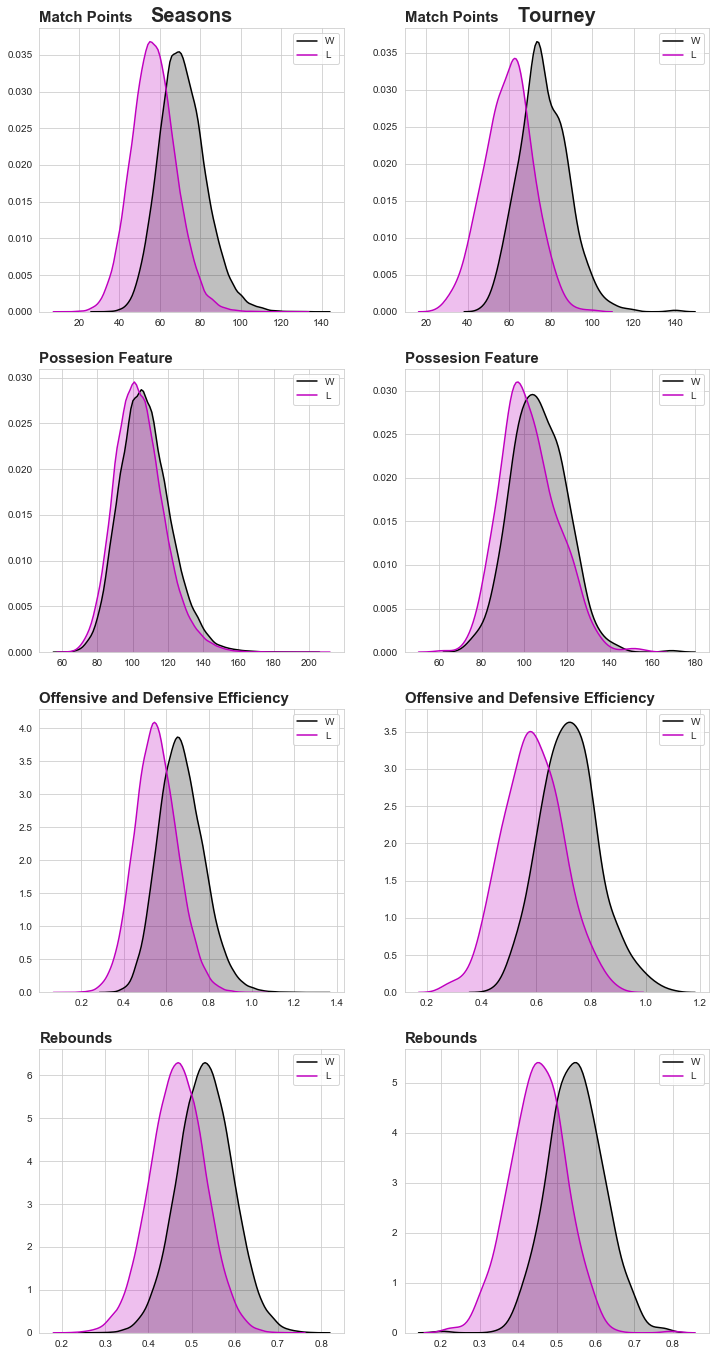

In [24]:
f, axes = plt.subplots (4,2, figsize=(12,24))
axes[0, 0].set_title('Seasons',loc='Center', fontsize=20, fontweight='bold')
axes[0, 1].set_title('Tourney',loc='Center', fontsize=20, fontweight='bold')

# Overall points combined
winners = seasons_results_detailed.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
losers = seasons_results_detailed.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)

add_plot_to_axes(axes[0, 0], winners, losers, 'Match Points')

winners = tourney_results_detailed.apply(lambda row: 2*row.WFGM + row.WFGM3 + row.WFTM, axis=1)
losers = tourney_results_detailed.apply(lambda row: 2*row.LFGM + row.LFGM3 + row.LFTM, axis=1)

add_plot_to_axes(axes[0, 1], winners, losers, 'Match Points')

# Possesion features advantage or loss
winners = seasons_results_detailed.apply(lambda row: row.WFGA + row.WTO + row.WFTA + row.WOR, axis=1)
losers = seasons_results_detailed.apply(lambda row: row.LFGA + row.LTO + row.LFTA + row.LOR, axis=1)

add_plot_to_axes(axes[1,0], winners, losers, 'Possesion Feature')

winners = tourney_results_detailed.apply(lambda row: row.WFGA + row.WTO + row.WFTA + row.WOR, axis=1)
losers = tourney_results_detailed.apply(lambda row: row.LFGA + row.LTO + row.LFTA + row.LOR, axis=1)

add_plot_to_axes(axes[1,1], winners, losers, 'Possesion Feature')

# Efficiency (Offensive and Defensive Combined)
winners = seasons_results_detailed.apply(lambda row: (2*row.WFGM + row.WFGM3 + row.WFTM)/(row.WFGA + row.WTO + row.WFTA + row.WOR), axis=1)
losers = seasons_results_detailed.apply(lambda row: (2*row.LFGM + row.LFGM3 + row.LFTM)/(row.LFGA + row.LTO + row.LFTA + row.LOR), axis=1)

add_plot_to_axes(axes[2,0], winners, losers, 'Offensive and Defensive Efficiency')

winners = tourney_results_detailed.apply(lambda row: (2*row.WFGM + row.WFGM3 + row.WFTM)/(row.WFGA + row.WTO + row.WFTA + row.WOR), axis=1)
losers = tourney_results_detailed.apply(lambda row: (2*row.LFGM + row.LFGM3 + row.LFTM)/(row.LFGA + row.LTO + row.LFTA + row.LOR), axis=1)

add_plot_to_axes(axes[2,1], winners, losers, 'Offensive and Defensive Efficiency')

# Total rebounds
winners = seasons_results_detailed.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
losers = seasons_results_detailed.apply(lambda row: (row.LDR + row.LOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)

add_plot_to_axes(axes[3,0], winners, losers, 'Rebounds')

winners = tourney_results_detailed.apply(lambda row: (row.WDR + row.WOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)
losers = tourney_results_detailed.apply(lambda row: (row.LDR + row.LOR) / (row.WDR + row.WOR + row.LDR + row.LOR), axis=1)

add_plot_to_axes(axes[3,1], winners, losers, 'Rebounds')

### 2.5. Relationship between Tournament Wins and Regular Season Wins

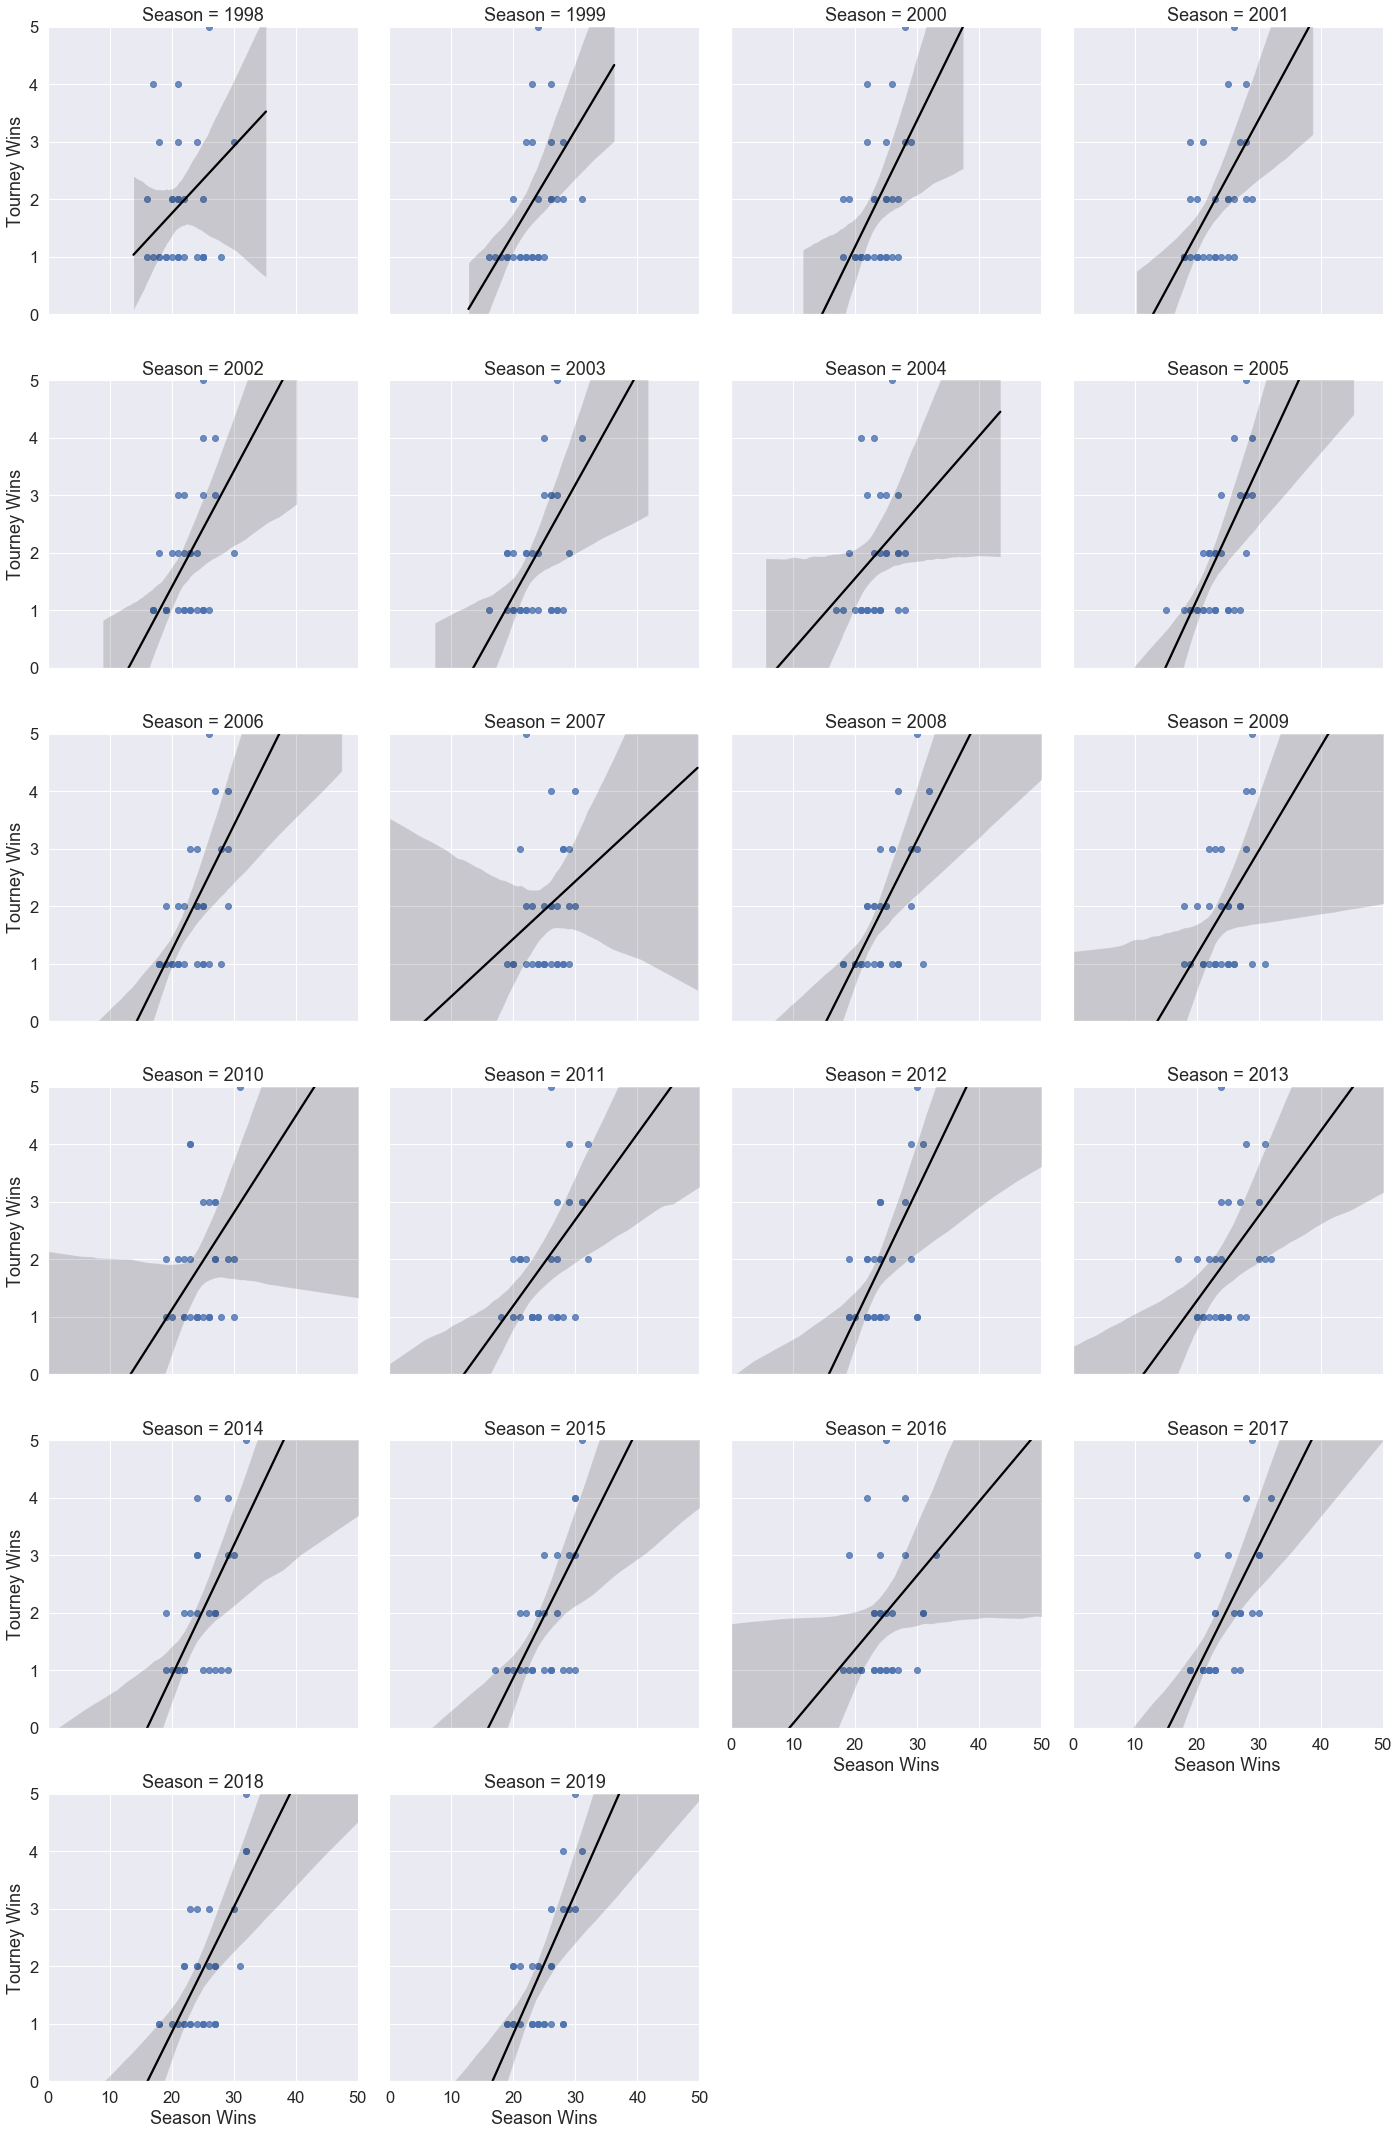

In [25]:
win_s = seasons_results.groupby(['Season','WTeamID'])['WTeamID'].count().to_frame('Season Wins')
win_t = tourney_results.groupby(['Season','WTeamID'])['WTeamID'].count().to_frame('Tourney Wins')
win_team = win_s.merge(win_t,on=['Season','WTeamID']).reset_index()
sns.set_style("whitegrid")
sns.set(font_scale=1.5)
sns.lmplot(x='Season Wins' , y='Tourney Wins', data=win_team, col='Season', col_wrap=4, line_kws={'color': 'black'}).set(xlim=(0, 50), ylim=(0, 5))

### 2.6. Attempted vs Made points

In [26]:
def make_jointplot(axes, winners, losers):
    axes = sns.kdeplot(winners.iloc[:, 0], winners.iloc[:, 1], cmap="Blues", shade=True, shade_lowest=False, ax=axes)
    axes = sns.kdeplot(losers.iloc[:, 0], losers.iloc[:, 1], cmap="Reds", shade=True, shade_lowest=False, ax=axes)

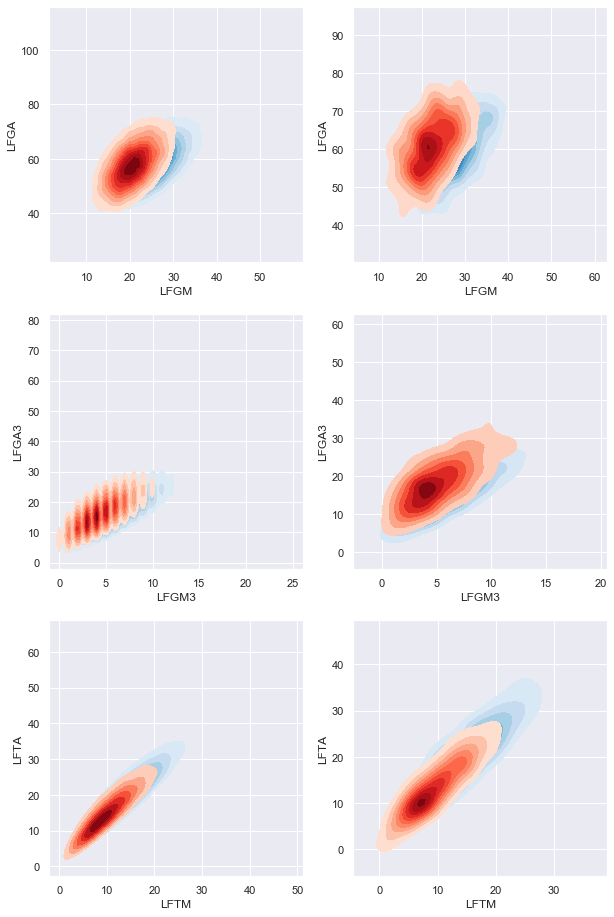

In [27]:
sns.set_style("white")
sns.set(font_scale=1)

axes[0, 0].set_title('Seasons',loc='Center', fontsize=20, fontweight='bold')
axes[0, 1].set_title('Tourney',loc='Center', fontsize=20, fontweight='bold')

f, axes = plt.subplots(3,2, figsize=(10,16))

winners = seasons_results_detailed[['WFGM', 'WFGA']]
losers = seasons_results_detailed[['LFGM', 'LFGA']]

make_jointplot(axes[0, 0], winners, losers)

winners = tourney_results_detailed[['WFGM', 'WFGA']]
losers = tourney_results_detailed[['LFGM', 'LFGA']]

make_jointplot(axes[0, 1], winners, losers)

winners = seasons_results_detailed[['WFGM3', 'WFGA3']]
losers = seasons_results_detailed[['LFGM3', 'LFGA3']]

make_jointplot(axes[1, 0], winners, losers)

winners = tourney_results_detailed[['WFGM3', 'WFGA3']]
losers = tourney_results_detailed[['LFGM3', 'LFGA3']]

make_jointplot(axes[1, 1], winners, losers)

winners = seasons_results_detailed[['WFTM', 'WFTA']]
losers = seasons_results_detailed[['LFTM', 'LFTA']]

make_jointplot(axes[2, 0], winners, losers)

winners = tourney_results_detailed[['WFTM', 'WFTA']]
losers = tourney_results_detailed[['LFTM', 'LFTA']]

make_jointplot(axes[2, 1], winners, losers)

### 2.7. Event types frequency

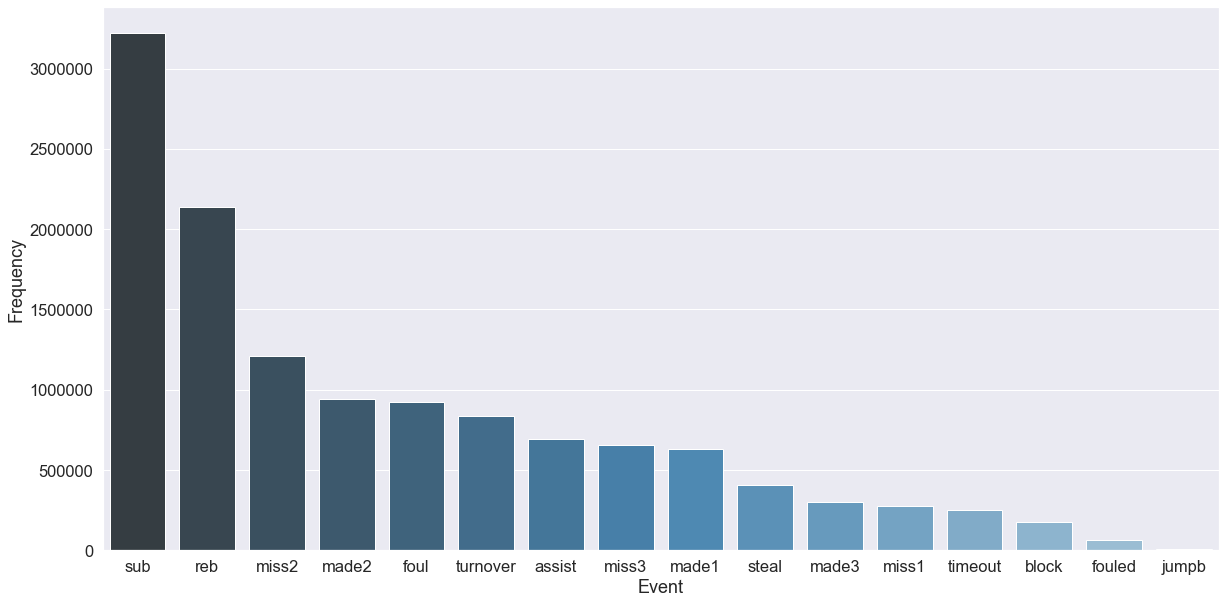

In [28]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1.5)

event = events['EventType'].value_counts()
event = event.reset_index()
event.columns = ['Event', 'Frequency']
sns.barplot(x="Event", y="Frequency", data=event, palette="Blues_d")

### 2.8. Frequency event area

In [29]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

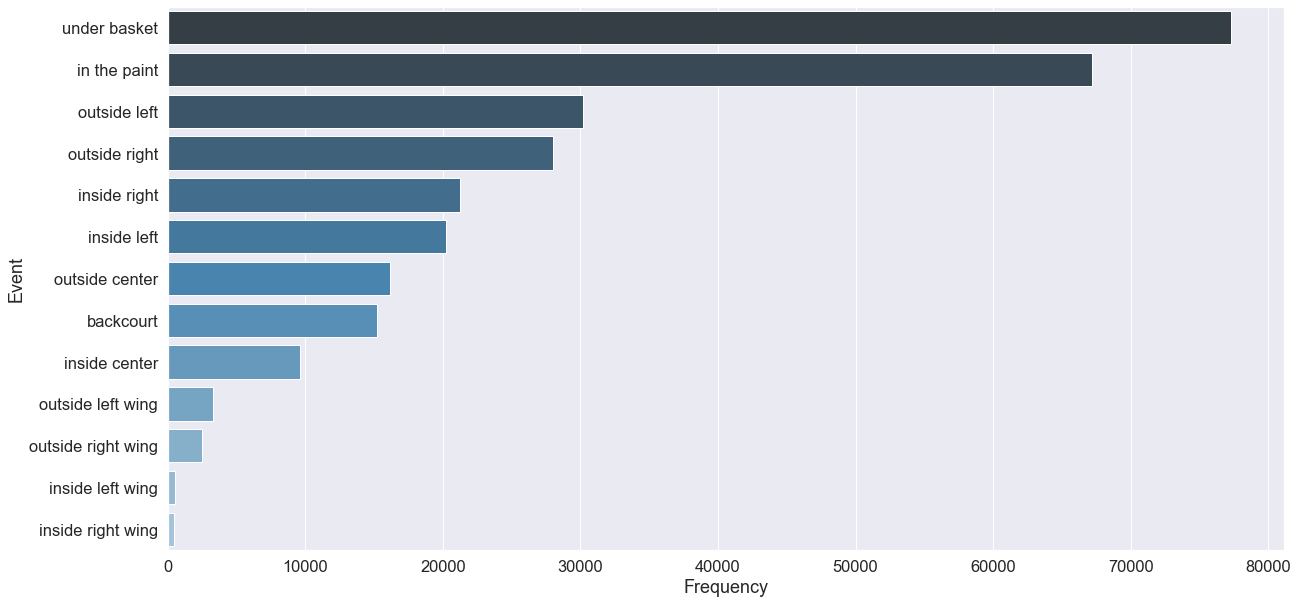

In [30]:
plt.figure(figsize=(20,10))
sns.set(font_scale=1.5)

event = events['Area'].map(area_mapping)
event.dropna(inplace=True)

event = event.value_counts()
event = event.reset_index()

event.columns = ['Event', 'Frequency']

sns.barplot(x="Frequency", y="Event", data=event, palette="Blues_d")

(0, 100)

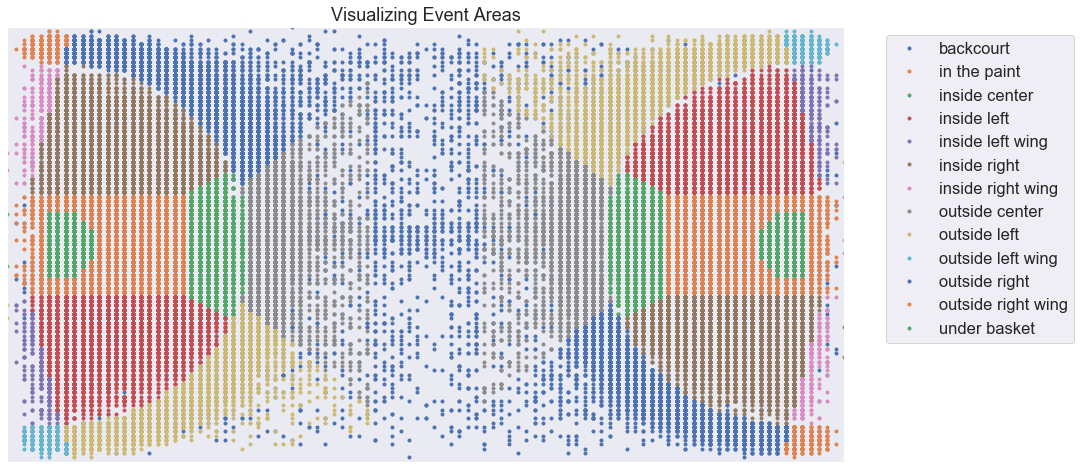

In [31]:
event = events['Area'].map(area_mapping)
event = pd.concat([events[['X', 'Y']], event], axis=1)

fig, ax = plt.subplots(figsize=(15, 8))
for i, d in event.loc[~event['Area'].isna()].groupby('Area'):
    d.plot(x='X', y='Y', style='.', label=i, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

### 2.9. Pool shot frequencies

Text(0.5, 1.0, 'Shot Heatmap')

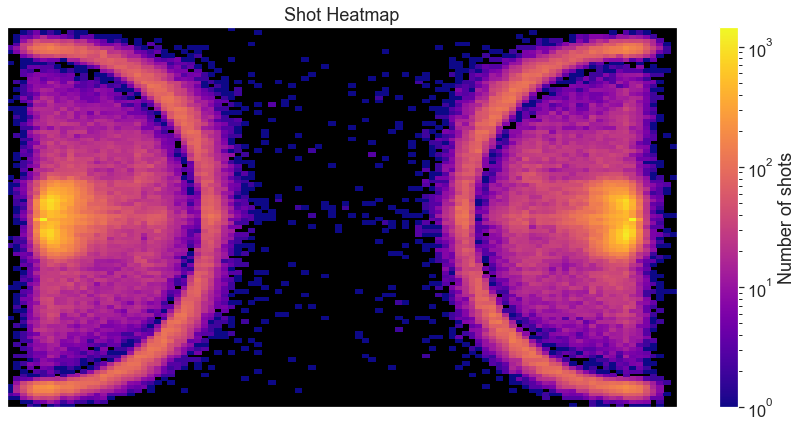

In [32]:
event = events[['EventType', 'X', 'Y']]
shot_events = event.loc[event['EventType'].isin(['miss3','made3','miss2','made2']) & (events['X'] != 0)]

N_bins = 100

fig, ax = plt.subplots(figsize=(15, 7))
ax = drawing.create_ncaa_full_court(ax, three_line='womens', paint_alpha=0.0,
                            court_color='black',
                            lines_alpha=0)

plt.hist2d(shot_events['X'].values + np.random.normal(0, 0.2, shot_events['X'].shape),
           shot_events['Y'].values + np.random.normal(0, 0.2, shot_events['Y'].shape),
           bins=N_bins, norm=colors.LogNorm(),
               cmap='plasma')

cb = plt.colorbar()
cb.set_label('Number of shots')

ax.set_title('Shot Heatmap')

## 3. Feature Engineering

### 3.1. Merging data (relations described in relations.pdf file)

In [33]:
dataset = pd.concat([tourney_results, seasons_results])

In [34]:
cities.drop('City', axis=1, inplace=True)
dataset = dataset.merge(game_cities.merge(cities, on=['CityID']),
                    how='right', on=['Season', 'WTeamID', 'LTeamID', 'DayNum'])

In [35]:
team_conferences = team_conferences[team_conferences.Season != 2020]

In [36]:
dataset = dataset.merge(team_conferences, left_on=['Season', 'WTeamID'],
                        right_on=['Season', 'TeamID']).drop('TeamID', axis=1)

dataset.rename(columns={"ConfAbbrev": "WConf"}, inplace=True)

dataset = dataset.merge(team_conferences, left_on=['Season', 'LTeamID'],
                        right_on=['Season', 'TeamID']).drop('TeamID', axis=1)

dataset.rename(columns={"ConfAbbrev": "LConf"}, inplace=True)

In [37]:
seeds = seeds.merge(seasons, on='Season')

In [38]:
seed_type = np.array([])
for seed in range(len(list(seeds.Seed)) // 8):
    if seed % 2:
        seed_type = np.append(seed_type, ['0'] * 8)
    else:
        seed_type = np.append(seed_type, ['1'] * 8)

In [39]:
seeds['SeedType'] = seed_type
seeds = seeds[seeds['Season'] >= 2010]

In [40]:
seeds = seeds[['Seed', 'TeamID', 'SeedType']]
seeds.rename(columns={"Seed": "WSeed", 'TeamID': 'WTeamID', 'SeedType': 'WSeedType'}, inplace=True)

In [41]:
dataset = dataset.merge(seeds, on='WTeamID', how='inner')
seeds.rename(columns={"WSeed": "LSeed", 'WTeamID': 'LTeamID', 'WSeedType': 'LSeedType'}, inplace=True)
dataset = dataset.merge(seeds, on='LTeamID', how='inner')

In [42]:
dataset

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,CRType,CityID,State,WConf,LConf,WSeed,WSeedType,LSeed,LSeedType
0,2010,138,3124,69,3201,55,N,0,NCAA,4027,CA,big_twelve,wac,X04,1,X13,0
1,2010,138,3124,69,3201,55,N,0,NCAA,4027,CA,big_twelve,wac,X04,1,X12,0
2,2010,138,3124,69,3201,55,N,0,NCAA,4027,CA,big_twelve,wac,X04,1,W12,0
3,2010,138,3124,69,3201,55,N,0,NCAA,4027,CA,big_twelve,wac,X04,1,Z15,0
4,2010,138,3124,69,3201,55,N,0,NCAA,4027,CA,big_twelve,wac,X04,1,W13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309516,2011,27,3364,63,3294,54,H,0,Regular,4310,CA,big_west,big_sky,W16,0,Z10,0
309517,2011,11,3377,62,3294,57,A,1,Regular,4134,CO,gwc,big_sky,X15,0,Z10,0
309518,2011,11,3377,62,3294,57,A,1,Regular,4134,CO,gwc,big_sky,Z08,1,Z10,0
309519,2012,40,3377,73,3294,48,H,0,Regular,4359,SD,summit,big_sky,X15,0,Z10,0


### 3.2. Change notations

In [43]:
dataset.drop_duplicates(subset=['WTeamID', 'LTeamID', 'DayNum', 'Season'], inplace=True)

In [44]:
dataset = pd.concat([dataset, pd.get_dummies(dataset['WLoc'], prefix='WLoc')], axis=1).drop('WLoc', axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset['CRType'], prefix='CRType')], axis=1).drop('CRType', axis=1)

In [45]:
def encounter_places_into_numericals(column):
    stdev = dataset[column].value_counts().std()
    num = []
    
    for value in dataset[column]:
        num.append(int(dataset[column][dataset[column] == value].value_counts().values) / stdev)
        
    return num    

In [46]:
dataset['WConf'] = encounter_places_into_numericals('WConf')
dataset['LConf'] = encounter_places_into_numericals('LConf')
dataset['State'] = encounter_places_into_numericals('State')
dataset['LConf'] = dataset['LConf'] * -1 

In [47]:
dataset.reset_index(drop=True, inplace=True)

In [48]:
dataset['WSeed'] = dataset['WSeed'].apply(lambda seed: int(seed[1:]))
dataset['LSeed'] = dataset['LSeed'].apply(lambda seed: int(seed[1:]))

In [49]:
dataset

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,CityID,State,WConf,LConf,WSeed,WSeedType,LSeed,LSeedType,WLoc_A,WLoc_H,WLoc_N,CRType_NCAA,CRType_Regular
0,2010,138,3124,69,3201,55,0,4027,4.420361,3.321515,-0.791779,4,1,13,0,0,0,1,1,0
1,2010,58,3390,68,3201,46,0,4126,4.420361,0.431099,-0.791779,1,1,13,0,1,0,0,0,1
2,2011,41,3390,77,3201,40,0,4331,4.420361,0.431099,-0.791779,1,1,13,0,0,1,0,0,1
3,2012,34,3390,93,3201,59,0,4126,4.420361,2.303300,-0.791779,1,1,13,0,1,0,0,0,1
4,2013,4,3390,72,3201,61,0,4331,4.420361,2.303300,-0.827769,1,1,13,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16159,2017,110,3226,68,3294,58,0,4134,0.892642,0.868357,-1.511579,14,0,10,0,1,0,0,0,1
16160,2017,128,3226,60,3294,59,0,4290,0.639131,0.868357,-1.511579,14,0,10,0,0,0,1,0,1
16161,2011,27,3364,63,3294,54,0,4310,4.420361,1.139333,-1.511579,16,0,10,0,0,1,0,0,1
16162,2011,11,3377,62,3294,57,1,4134,0.892642,0.030793,-1.511579,15,0,10,0,1,0,0,0,1


### 3.3. Label teams by dividing between winners and losers in train set

In [50]:
train_0 = dataset.drop(['WTeamID', 'WScore', 'WConf', 'WSeed', 'WSeedType'], axis=1)
train_1 = dataset.drop(['LTeamID', 'LScore', 'LConf', 'LSeed', 'LSeedType'], axis=1)

In [51]:
train_1['Result'] = 1
train_0['Result'] = 0

In [52]:
train_0['WLoc_A'][train_0['WLoc_N'] == 0] = -(train_0['WLoc_A'] - 1)
train_0['WLoc_H'][train_0['WLoc_N'] == 0] = -(train_0['WLoc_H'] - 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [53]:
columns = ['Season', 'DayNum', 'TeamID', 'Score', 'NumOT', 'CityID', 'State', 'Conf', 'Seed', 'SeedType',
                  'Loc_A', 'Loc_H', 'Loc_N', 'CRType_NCAA', 'CRType_Regular', 'Result']

In [54]:
train_0.columns = columns
train_1.columns = columns

In [55]:
train = pd.concat([train_0, train_1])

In [56]:
train.sort_values(['Season', 'DayNum'], ignore_index=True, inplace=True)

In [57]:
train = train.astype('float64')
train

,Season,DayNum,TeamID,Score,NumOT,CityID,State,Conf,Seed,SeedType,Loc_A,Loc_H,Loc_N,CRType_NCAA,CRType_Regular,Result
0,2010.0,11.0,3211.0,71.0,1.0,4046.0,0.503450,-0.465101,7.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2010.0,11.0,3341.0,68.0,0.0,4198.0,4.420361,-1.370387,16.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2010.0,11.0,3277.0,74.0,0.0,4091.0,2.545814,-3.856464,5.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,2010.0,11.0,3151.0,61.0,0.0,4170.0,2.385138,-0.714263,13.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,2010.0,11.0,3364.0,76.0,0.0,4310.0,4.420361,-2.020975,16.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32323,2019.0,151.0,3332.0,67.0,0.0,4342.0,3.184945,-2.389180,10.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
32324,2019.0,151.0,3323.0,81.0,0.0,4342.0,3.184945,2.978689,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
32325,2019.0,151.0,3124.0,72.0,0.0,4342.0,3.184945,3.321515,4.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
32326,2019.0,153.0,3323.0,81.0,0.0,4342.0,3.184945,-2.973325,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


### 3.4. Making test set basing on averaging train set scores with new samples

In [58]:
test = sample_submission
test['Season'] = test['ID'].map(lambda x: int(x[:4]))
test['WTeamID'] = test['ID'].map(lambda x: int(x[5:9]))
test['LTeamID'] = test['ID'].map(lambda x: int(x[10:14]))

In [59]:
test.drop(['ID', 'Pred'], axis=1, inplace=True)

In [60]:
test_0 = test[['Season', 'LTeamID']]
test_0['Result'] = 0 
test_0.rename(columns={"LTeamID": "TeamID"}, inplace=True)
test_1 = test[['Season', 'WTeamID']]
test_1['Result'] = 1
test_1.rename(columns={"WTeamID": "TeamID"}, inplace=True)

In [61]:
test = pd.concat([test_0, test_1])
test.reset_index(drop=True, inplace=True)

In [62]:
columns = {'DayNum': 0, 'Score': 0, 'NumOT': 0, 'CityID': 0, 'State': 0, 'Conf': 0, 'Seed': 0, 'SeedType': 0, 
     'Loc_A': 0, 'Loc_H': 0, 'Loc_N': 0, 'CRType_NCAA': 0, 'CRType_Regular': 0 }
test = test.assign(**columns)
test = test.astype('float64')

In [63]:
def supplementary(row):
    segment = train[(train['TeamID'] == row['TeamID']) & (train['Result'] == row['Result']) & (train['Season'] == row['Season'])]
    
    if not len(segment):
        segment = train[(train['TeamID'] == row['TeamID']) & (train['Result'] == row['Result'])]

    row['NumOT'] = int(segment['NumOT'].mode()[0])
    row['Seed'] = int(segment['Seed'].mode()[0])
    row['SeedType'] = int(segment['SeedType'].mode()[0])
    
    row['CRType_NCAA'] = int(''.join(['1' if segment['CRType_NCAA'].sum() > segment['CRType_Regular'].sum() else '0'])) 
    row['CRType_Regular'] = abs(row['CRType_NCAA'] - 1)
    
    row['DayNum'] = int(segment['DayNum'].mean())
    row['CityID'] = int(segment['CityID'].mean())
    
    row['State'] = segment['State'].mean()
    row['Conf'] = segment['Conf'].mean()
    
    if (segment['Loc_N'].sum() >= row['Loc_H'].sum()) and (segment['Loc_N'].sum() >= row['Loc_A'].sum()):
        row['Loc_H'] = 0
        row['Loc_A'] = 0
        row['Loc_N'] = 1
        
    else:
        row['Loc_N'] = 0
        row['Loc_H'] = int(''.join(['1' if segment['Loc_H'].sum() > segment['Loc_A'].sum() else '0']))
        row['Loc_A'] = abs(row['Loc_H'] - 1)
    
    return row

In [64]:
for index, row in test.iterrows():
    row = supplementary(row)

In [65]:
test.drop('Score', axis=1, inplace=True)
test.drop_duplicates(inplace=True, ignore_index=True)
test

,Season,TeamID,Result,DayNum,NumOT,CityID,State,Conf,Seed,SeedType,Loc_A,Loc_H,Loc_N,CRType_NCAA,CRType_Regular
0,2015.0,3107.0,0.0,63.0,0.0,4104.0,1.968572,-0.836075,14.0,0.0,0.0,0.0,1.0,0.0,1.0
1,2015.0,3110.0,0.0,51.0,0.0,4282.0,1.202686,-1.021562,14.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2015.0,3113.0,0.0,96.0,0.0,4224.0,1.409779,-2.389180,7.0,1.0,0.0,0.0,1.0,0.0,1.0
3,2015.0,3114.0,0.0,82.0,0.0,4233.0,0.755175,-0.553692,11.0,0.0,0.0,0.0,1.0,0.0,1.0
4,2015.0,3116.0,0.0,86.0,0.0,4167.0,1.822911,-3.335994,6.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019.0,3401.0,1.0,72.0,0.0,4120.0,3.011935,3.387206,2.0,1.0,0.0,0.0,1.0,0.0,1.0
626,2019.0,3406.0,1.0,83.0,0.0,4240.0,1.293973,0.441363,15.0,0.0,0.0,0.0,1.0,0.0,1.0
627,2019.0,3413.0,1.0,91.0,0.0,4180.0,4.206127,1.139333,16.0,0.0,0.0,0.0,1.0,0.0,1.0
628,2019.0,3416.0,1.0,62.0,0.0,4261.0,2.640037,1.042849,13.0,0.0,0.0,0.0,1.0,0.0,1.0


## 4. Modeling & Learning

In [66]:
X_train = train.drop('Score', axis=1)
y_train = train['Score']
X_test = test

predictions = []

X_train = X_train.reindex(columns=sorted(X_train.columns))
X_test = X_test.reindex(columns=sorted(X_test.columns))

### 4.1. Random Forest

In [67]:
rf_params = {"n_estimators": np.linspace(100, 10000, num=3, dtype='int64'),
             'max_depth': np.append(np.linspace(10, 100, num=2, dtype='int64'), [None]),
             "bootstrap": [True],
             "oob_score": [False],
             "random_state": [42],
             "verbose": [False],
             "warm_start": [False],
             "n_jobs": [-1]
}

NameError: name 'xddsx' is not defined

In [ ]:
rf_model = RandomForestRegressor(**rf_params)
kf = KFold(n_splits=3, random_state=42)
clf = GridSearchCV(rf_model, rf_params, cv=5)

In [ ]:
for train_index, test_index in tqdm(kf.split(X_train), total=kf.get_n_splits(), desc="Fold"):
    X_train_sub, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_sub, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    clf.fit(X_train_sub, y_train_sub)
    print(clf.score(X_val, y_val))

In [ ]:
preds = clf.predict(X_test)
preds

In [ ]:
predictions.append(preds)

### 4.2. XGBoost

In [68]:
xg_params = {
    'num_parallel_tree': np.linspace(10, 1000, num=3, dtype='int64'), 
    'max_depth': np.append(np.linspace(10, 100, num=2, dtype='int64'), [None]),
    'booster': 'gbtree',
    'learning_rate': np.geomspace(0.05, 0.5, num=5),
    'reg_alpha': np.logspace(-5, 5, num=4),
    'reg_lambda': np.logspace(-5, 5, num=4),
    'verbosity': 1,
    'learning_rate': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'n_jobs': -1
}
search_params = [
    (num_parallel_tree, max_depth, learning_rate, reg_alpha, reg_lambda)
    for num_parallel_tree in np.linspace(10, 1000, num=3, dtype='int64')
    for max_depth in np.append(np.linspace(10, 100, num=2, dtype='int64'), [None])
    for learning_rate in np.geomspace(0.05, 0.5, num=5)
    for reg_alpha in np.logspace(-5, 5, num=4)
    for reg_lambda in np.logspace(-5, 5, num=4)
]

In [69]:
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train,
                                                    test_size=0.33, random_state=42)

In [70]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_train_val, label=y_train_val)
dtest = xgb.DMatrix(X_test)

In [71]:
min_rmse = float("Inf")
best_params = []
params = {}

for num_parallel_tree, max_depth, learning_rate, reg_alpha, reg_lambda in search_params:
    params['num_parallel_tree'] = num_parallel_tree
    params['max_depth'] = max_depth
    params['learning_rate'] = learning_rate
    params['reg_alpha'] = reg_alpha
    params['reg_lambda'] = reg_lambda
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=20,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = [num_parallel_tree, max_depth, learning_rate, reg_alpha, reg_lambda]

	RMSE 25.6235 for 19 rounds
	RMSE 25.713905599999997 for 19 rounds


In [72]:
xg_params['num_parallel_tree'] = best_params[0]
xg_params['max_depth'] = best_params[1]
xg_params['learning_rate'] = best_params[2]
xg_params['reg_alpha'] = best_params[3]
xg_params['reg_lambda'] = best_params[4]

In [73]:
xg_params

{'num_parallel_tree': 10,
 'max_depth': 10,
 'booster': 'gbtree',
 'learning_rate': 0.049999999999999996,
 'reg_alpha': 1e-05,
 'reg_lambda': 1e-05,
 'verbosity': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'random_state': 42,
 'n_jobs': -1}

In [74]:
bst = xgb.train(
    xg_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dval, "eval")],
    early_stopping_rounds=100
)

[0]	eval-rmse:62.82667
Will train until eval-rmse hasn't improved in 10 rounds.
[1]	eval-rmse:59.77383
[2]	eval-rmse:56.87520
[3]	eval-rmse:54.12949
[4]	eval-rmse:51.52847
[5]	eval-rmse:49.05997
[6]	eval-rmse:46.71834
[7]	eval-rmse:44.50581
[8]	eval-rmse:42.40263
[9]	eval-rmse:40.41379
[10]	eval-rmse:38.53509
[11]	eval-rmse:36.75603
[12]	eval-rmse:35.06667
[13]	eval-rmse:33.47494
[14]	eval-rmse:31.96713
[15]	eval-rmse:30.54433
[16]	eval-rmse:29.19783
[17]	eval-rmse:27.92963
[18]	eval-rmse:26.73459
[19]	eval-rmse:25.60470


In [75]:
preds = bst.predict(dtest)
preds

array([35.835064, 35.503685, 35.9922  , 35.634323, 34.215076, 38.250805,
       36.557255, 35.669464, 36.42551 , 35.953236, 53.631184, 37.057827,
       36.406956, 40.814137, 38.977192, 36.82643 , 39.372864, 36.612186,
       35.557487, 43.864986, 38.884537, 36.928646, 39.819164, 35.612156,
       39.473915, 38.383595, 40.450176, 40.026157, 39.954723, 38.420006,
       37.70928 , 41.193417, 36.93998 , 39.926605, 40.27017 , 36.554863,
       39.98864 , 38.30476 , 40.974052, 39.500313, 38.370293, 38.51365 ,
       36.33924 , 37.02865 , 36.91887 , 40.642784, 35.424942, 34.25469 ,
       37.982567, 37.8999  , 36.660027, 36.623436, 37.80192 , 38.541176,
       39.448586, 36.970455, 39.463005, 38.930367, 35.12461 , 38.520813,
       38.67486 , 36.84041 , 36.42739 , 36.27866 , 35.9922  , 36.517662,
       33.70184 , 38.250805, 37.47417 , 39.067795, 36.847507, 36.96538 ,
       36.24405 , 36.386166, 38.519577, 40.814137, 36.515266, 38.243362,
       38.706272, 36.347485, 38.243362, 37.656094, 

In [ ]:
predictions.append(preds)

### 4.3. LightGBM

In [179]:
lgbm_params = { 
              'learning_rate': hp.choice('learning_rate', np.geomspace(0.05, 0.5, num=5)),
              'feature_fraction': hp.choice('feature_fraction', np.linspace(0.4, 1, num=4)),
              'bagging_fraction': hp.choice('bagging_fraction', np.linspace(0.4, 1, num=4)),
              'bagging_freq': hp.choice('bagging_freq', np.linspace(1, 5, num=3, dtype='int64')),
              'lambda_l1': hp.choice('lambda_l1', np.logspace(-5, 5, num=8)),
              'lambda_l2': hp.choice('lambda_l2', np.logspace(-5, 5, num=8)),
              'drop_rate': hp.choice('drop_rate', np.logspace(-1, -0.6, num=3)),
              'verbose': 1,
              'is_training_metric': True,
              'metric': {'rmse'}
}

In [180]:
dtrain = lgbm.Dataset(data=X_train, label=y_train)
dval = lgbm.Dataset(data=X_train_val, label=y_train_val)

In [181]:
def objective(lgbm_params):
    gbm = lgbm.cv(lgbm_params, dtrain, num_boost_round=1000, nfold=3)
    return sum(gbm['rmse-mean']) / len(gbm['rmse-mean'])

best = fmin(fn=objective,
            space=lgbm_params,
            algo=tpe.suggest,
            max_evals=100)

  0%|                                                                          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  1%|▍                                               | 1/100 [00:02<03:44,  2.27s/trial, best loss: 10.203126109983463]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  2%|▉                                               | 2/100 [00:05<03:58,  2.44s/trial, best loss: 10.203126109983463]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  3%|█▍                                              | 3/100 [00:06<03:37,  2.24s/trial, best loss: 10.203126109983463]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  4%|█▉                                              | 4/100 [00:09<03:38,  2.28s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  5%|██▍                                             | 5/100 [00:11<03:36,  2.27s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  6%|██▉                                             | 6/100 [00:13<03:35,  2.29s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  7%|███▎                                            | 7/100 [00:16<03:35,  2.32s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  8%|███▊                                            | 8/100 [00:18<03:30,  2.28s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



  9%|████▎                                           | 9/100 [00:20<03:32,  2.33s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 10%|████▋                                          | 10/100 [00:23<03:30,  2.34s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 11%|█████▏                                         | 11/100 [00:25<03:26,  2.32s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 12%|█████▋                                         | 12/100 [00:26<02:53,  1.97s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 13%|██████                                         | 13/100 [00:29<03:09,  2.18s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 14%|██████▌                                        | 14/100 [00:31<03:03,  2.14s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 15%|███████                                        | 15/100 [00:33<03:01,  2.13s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 16%|███████▌                                       | 16/100 [00:35<03:07,  2.24s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 17%|███████▉                                       | 17/100 [00:38<03:10,  2.29s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 18%|████████▍                                      | 18/100 [00:41<03:17,  2.41s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 19%|████████▉                                      | 19/100 [00:43<03:17,  2.44s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 20%|█████████▍                                     | 20/100 [00:45<03:00,  2.25s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 21%|█████████▊                                     | 21/100 [00:46<02:27,  1.87s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 22%|██████████▎                                    | 22/100 [00:48<02:28,  1.90s/trial, best loss: 10.152030898060534]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 23%|██████████▊                                    | 23/100 [00:50<02:23,  1.87s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 24%|███████████▎                                   | 24/100 [00:51<02:03,  1.63s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 25%|███████████▊                                   | 25/100 [00:52<01:45,  1.40s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 26%|████████████▏                                  | 26/100 [00:54<02:07,  1.72s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 27%|████████████▋                                  | 27/100 [00:56<02:05,  1.72s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 28%|█████████████▏                                 | 28/100 [00:58<02:15,  1.88s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 29%|█████████████▋                                 | 29/100 [01:00<02:24,  2.03s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 30%|██████████████                                 | 30/100 [01:02<02:13,  1.91s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 31%|██████████████▌                                | 31/100 [01:05<02:26,  2.13s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 32%|███████████████                                | 32/100 [01:06<02:16,  2.01s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 33%|███████████████▌                               | 33/100 [01:09<02:21,  2.12s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 34%|███████████████▉                               | 34/100 [01:11<02:23,  2.17s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 35%|████████████████▍                              | 35/100 [01:12<01:57,  1.81s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 36%|████████████████▉                              | 36/100 [01:13<01:40,  1.58s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 37%|█████████████████▍                             | 37/100 [01:16<02:10,  2.06s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 38%|█████████████████▊                             | 38/100 [01:18<01:59,  1.93s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 39%|██████████████████▎                            | 39/100 [01:20<02:01,  1.99s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 40%|██████████████████▊                            | 40/100 [01:23<02:12,  2.20s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 41%|███████████████████▎                           | 41/100 [01:25<02:18,  2.35s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 42%|███████████████████▋                           | 42/100 [01:28<02:12,  2.29s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 43%|████████████████████▏                          | 43/100 [01:30<02:15,  2.39s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 44%|████████████████████▋                          | 44/100 [01:32<02:10,  2.34s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 45%|█████████████████████▏                         | 45/100 [01:33<01:48,  1.98s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 46%|█████████████████████▌                         | 46/100 [01:35<01:38,  1.83s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 47%|██████████████████████                         | 47/100 [01:38<01:48,  2.05s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 48%|██████████████████████▌                        | 48/100 [01:40<01:52,  2.17s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 49%|███████████████████████                        | 49/100 [01:43<01:56,  2.29s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 50%|███████████████████████▌                       | 50/100 [01:45<01:52,  2.26s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 51%|███████████████████████▉                       | 51/100 [01:47<01:56,  2.38s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 52%|████████████████████████▍                      | 52/100 [01:50<02:00,  2.51s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 53%|████████████████████████▉                      | 53/100 [01:52<01:51,  2.38s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 54%|█████████████████████████▍                     | 54/100 [01:53<01:28,  1.93s/trial, best loss: 10.146912123881672]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 55%|█████████████████████████▊                     | 55/100 [01:55<01:24,  1.87s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 56%|██████████████████████████▎                    | 56/100 [01:57<01:22,  1.88s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 57%|██████████████████████████▊                    | 57/100 [01:59<01:21,  1.89s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 58%|███████████████████████████▎                   | 58/100 [02:00<01:17,  1.83s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 59%|███████████████████████████▋                   | 59/100 [02:02<01:13,  1.80s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 60%|████████████████████████████▏                  | 60/100 [02:04<01:10,  1.76s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 61%|████████████████████████████▋                  | 61/100 [02:05<01:07,  1.72s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 62%|█████████████████████████████▏                 | 62/100 [02:07<01:06,  1.75s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 63%|█████████████████████████████▌                 | 63/100 [02:09<01:03,  1.72s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 64%|██████████████████████████████                 | 64/100 [02:11<01:01,  1.71s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 65%|██████████████████████████████▌                | 65/100 [02:13<01:07,  1.92s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 66%|███████████████████████████████                | 66/100 [02:15<01:02,  1.84s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 67%|███████████████████████████████▍               | 67/100 [02:16<00:58,  1.78s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 68%|███████████████████████████████▉               | 68/100 [02:18<00:55,  1.74s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 69%|████████████████████████████████▍              | 69/100 [02:20<00:53,  1.71s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 70%|████████████████████████████████▉              | 70/100 [02:21<00:50,  1.69s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 71%|█████████████████████████████████▎             | 71/100 [02:23<00:45,  1.58s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 72%|█████████████████████████████████▊             | 72/100 [02:24<00:45,  1.62s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 73%|██████████████████████████████████▎            | 73/100 [02:25<00:38,  1.43s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 74%|██████████████████████████████████▊            | 74/100 [02:27<00:43,  1.66s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 75%|███████████████████████████████████▎           | 75/100 [02:29<00:42,  1.70s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 76%|███████████████████████████████████▋           | 76/100 [02:31<00:40,  1.69s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 77%|████████████████████████████████████▏          | 77/100 [02:32<00:34,  1.50s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 78%|████████████████████████████████████▋          | 78/100 [02:34<00:33,  1.53s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 79%|█████████████████████████████████████▏         | 79/100 [02:36<00:36,  1.74s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 80%|█████████████████████████████████████▌         | 80/100 [02:37<00:32,  1.64s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 81%|██████████████████████████████████████         | 81/100 [02:39<00:32,  1.70s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 82%|██████████████████████████████████████▌        | 82/100 [02:41<00:33,  1.86s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 83%|███████████████████████████████████████        | 83/100 [02:43<00:30,  1.80s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 84%|███████████████████████████████████████▍       | 84/100 [02:46<00:32,  2.05s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 85%|███████████████████████████████████████▉       | 85/100 [02:46<00:25,  1.69s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 86%|████████████████████████████████████████▍      | 86/100 [02:48<00:23,  1.66s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 87%|████████████████████████████████████████▉      | 87/100 [02:49<00:18,  1.43s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 88%|█████████████████████████████████████████▎     | 88/100 [02:51<00:21,  1.76s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 89%|█████████████████████████████████████████▊     | 89/100 [02:54<00:21,  1.95s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 90%|██████████████████████████████████████████▎    | 90/100 [02:55<00:18,  1.84s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 91%|██████████████████████████████████████████▊    | 91/100 [02:58<00:18,  2.08s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 92%|███████████████████████████████████████████▏   | 92/100 [03:00<00:15,  1.95s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 93%|███████████████████████████████████████████▋   | 93/100 [03:01<00:11,  1.63s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 94%|████████████████████████████████████████████▏  | 94/100 [03:03<00:11,  1.88s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 95%|████████████████████████████████████████████▋  | 95/100 [03:04<00:08,  1.63s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 96%|█████████████████████████████████████████████  | 96/100 [03:06<00:06,  1.61s/trial, best loss: 10.124542862985253]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 97%|█████████████████████████████████████████████▌ | 97/100 [03:07<00:04,  1.62s/trial, best loss: 10.121236576581405]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 98%|██████████████████████████████████████████████ | 98/100 [03:09<00:03,  1.66s/trial, best loss: 10.121236576581405]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



 99%|██████████████████████████████████████████████▌| 99/100 [03:11<00:01,  1.66s/trial, best loss: 10.121236576581405]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



100%|██████████████████████████████████████████████| 100/100 [03:13<00:00,  1.94s/trial, best loss: 10.121236576581405]


In [182]:
lgbm_params['bagging_fraction'] = np.linspace(0.4, 1, num=4)[best['bagging_fraction']]
lgbm_params['feature_fraction'] = np.linspace(0.4, 1, num=4)[best['feature_fraction']]
lgbm_params['bagging_freq'] = np.linspace(1, 5, num=3, dtype='int64')[best['bagging_freq']]
lgbm_params['drop_rate'] = np.logspace(-1, -0.6, num=3)[best['drop_rate']]
lgbm_params['lambda_l1'] = np.logspace(-5, -0.5, num=8)[best['lambda_l1']]
lgbm_params['lambda_l2'] = np.logspace(-5, -0.5, num=8)[best['lambda_l2']]
lgbm_params['learning_rate'] = np.geomspace(0.05, 0.5, num=5)[best['learning_rate']]

In [183]:
lgbm_params

{'learning_rate': 0.08891397050194613,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 5,
 'lambda_l1': 4.393970560760795e-05,
 'lambda_l2': 0.0008483428982440725,
 'drop_rate': 0.251188643150958,
 'verbose': 1,
 'is_training_metric': True,
 'metric': {'rmse'}}

In [184]:
bst = lgbm.train(lgbm_params, dtrain, valid_sets=dval, 
                 num_boost_round=1000, verbose_eval=1, early_stopping_rounds=100)

[1]	valid_0's rmse: 13.3948
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 12.9944
[3]	valid_0's rmse: 12.6671
[4]	valid_0's rmse: 12.3769
[5]	valid_0's rmse: 12.1079
[6]	valid_0's rmse: 11.8808
[7]	valid_0's rmse: 11.8219
[8]	valid_0's rmse: 11.752
[9]	valid_0's rmse: 11.5718
[10]	valid_0's rmse: 11.4314
[11]	valid_0's rmse: 11.3058
[12]	valid_0's rmse: 11.192
[13]	valid_0's rmse: 11.1525
[14]	valid_0's rmse: 11.0611
[15]	valid_0's rmse: 10.9919
[16]	valid_0's rmse: 10.926
[17]	valid_0's rmse: 10.8987
[18]	valid_0's rmse: 10.8673
[19]	valid_0's rmse: 10.8402
[20]	valid_0's rmse: 10.7833
[21]	valid_0's rmse: 10.7406
[22]	valid_0's rmse: 10.6938
[23]	valid_0's rmse: 10.6648
[24]	valid_0's rmse: 10.6314
[25]	valid_0's rmse: 10.6036
[26]	valid_0's rmse: 10.5849
[27]	valid_0's rmse: 10.5639
[28]	valid_0's rmse: 10.5473
[29]	valid_0's rmse: 10.5276
[30]	valid_0's rmse: 10.5161
[31]	valid_0's rmse: 10.4964
[32]	valid_0's rmse: 10.482
[33]	valid_0's rmse: 10

[276]	valid_0's rmse: 9.95727
[277]	valid_0's rmse: 9.95588
[278]	valid_0's rmse: 9.9534
[279]	valid_0's rmse: 9.95254
[280]	valid_0's rmse: 9.95199
[281]	valid_0's rmse: 9.95143
[282]	valid_0's rmse: 9.95025
[283]	valid_0's rmse: 9.94956
[284]	valid_0's rmse: 9.94892
[285]	valid_0's rmse: 9.94893
[286]	valid_0's rmse: 9.94818
[287]	valid_0's rmse: 9.94705
[288]	valid_0's rmse: 9.94745
[289]	valid_0's rmse: 9.94743
[290]	valid_0's rmse: 9.94763
[291]	valid_0's rmse: 9.94752
[292]	valid_0's rmse: 9.94828
[293]	valid_0's rmse: 9.94518
[294]	valid_0's rmse: 9.9433
[295]	valid_0's rmse: 9.93945
[296]	valid_0's rmse: 9.93976
[297]	valid_0's rmse: 9.93963
[298]	valid_0's rmse: 9.94019
[299]	valid_0's rmse: 9.94
[300]	valid_0's rmse: 9.94057
[301]	valid_0's rmse: 9.94051
[302]	valid_0's rmse: 9.93866
[303]	valid_0's rmse: 9.93802
[304]	valid_0's rmse: 9.93886
[305]	valid_0's rmse: 9.93839
[306]	valid_0's rmse: 9.93828
[307]	valid_0's rmse: 9.93582
[308]	valid_0's rmse: 9.93602
[309]	valid_0's

[550]	valid_0's rmse: 9.88184
[551]	valid_0's rmse: 9.88234
[552]	valid_0's rmse: 9.88249
[553]	valid_0's rmse: 9.8829
[554]	valid_0's rmse: 9.88306
[555]	valid_0's rmse: 9.88328
[556]	valid_0's rmse: 9.88307
[557]	valid_0's rmse: 9.88323
[558]	valid_0's rmse: 9.88332
[559]	valid_0's rmse: 9.88301
[560]	valid_0's rmse: 9.88289
[561]	valid_0's rmse: 9.883
[562]	valid_0's rmse: 9.88386
[563]	valid_0's rmse: 9.88408
[564]	valid_0's rmse: 9.88455
[565]	valid_0's rmse: 9.8841
[566]	valid_0's rmse: 9.88476
[567]	valid_0's rmse: 9.88473
[568]	valid_0's rmse: 9.8847
[569]	valid_0's rmse: 9.88451
[570]	valid_0's rmse: 9.88458
[571]	valid_0's rmse: 9.88386
[572]	valid_0's rmse: 9.88409
[573]	valid_0's rmse: 9.884
[574]	valid_0's rmse: 9.88385
[575]	valid_0's rmse: 9.8832
[576]	valid_0's rmse: 9.88264
[577]	valid_0's rmse: 9.88266
[578]	valid_0's rmse: 9.88242
[579]	valid_0's rmse: 9.88228
[580]	valid_0's rmse: 9.88261
[581]	valid_0's rmse: 9.88276
[582]	valid_0's rmse: 9.88244
[583]	valid_0's rm

[824]	valid_0's rmse: 9.86703
[825]	valid_0's rmse: 9.86745
[826]	valid_0's rmse: 9.8687
[827]	valid_0's rmse: 9.86907
[828]	valid_0's rmse: 9.86862
[829]	valid_0's rmse: 9.86881
[830]	valid_0's rmse: 9.86982
[831]	valid_0's rmse: 9.87031
[832]	valid_0's rmse: 9.86917
[833]	valid_0's rmse: 9.86955
[834]	valid_0's rmse: 9.87001
[835]	valid_0's rmse: 9.86988
[836]	valid_0's rmse: 9.87039
[837]	valid_0's rmse: 9.87012
[838]	valid_0's rmse: 9.86989
[839]	valid_0's rmse: 9.87016
[840]	valid_0's rmse: 9.86957
[841]	valid_0's rmse: 9.86887
[842]	valid_0's rmse: 9.8696
[843]	valid_0's rmse: 9.8692
[844]	valid_0's rmse: 9.86881
[845]	valid_0's rmse: 9.86894
[846]	valid_0's rmse: 9.86922
[847]	valid_0's rmse: 9.86788
[848]	valid_0's rmse: 9.86843
[849]	valid_0's rmse: 9.86853
[850]	valid_0's rmse: 9.86907
[851]	valid_0's rmse: 9.86912
[852]	valid_0's rmse: 9.8682
[853]	valid_0's rmse: 9.86805
[854]	valid_0's rmse: 9.86814
[855]	valid_0's rmse: 9.86809
[856]	valid_0's rmse: 9.86768
[857]	valid_0'

In [185]:
preds = bst.predict(X_test)
preds

array([53.05347129, 54.360524  , 52.43748318, 53.62223877, 53.03087156,
       66.40144698, 54.54014597, 61.77355748, 57.09517119, 48.86624409,
       80.15638875, 57.6406051 , 63.48066473, 66.2207405 , 58.36641057,
       59.53640097, 62.93894887, 57.37615208, 60.34914794, 65.48344551,
       59.81974909, 60.44354617, 64.30958794, 53.78749011, 62.28229596,
       54.58842962, 64.06566025, 62.40308545, 62.0068867 , 60.57883294,
       56.59167205, 60.70838539, 58.73821073, 60.4610201 , 62.9464076 ,
       52.83205293, 61.14300907, 58.96022267, 63.74483289, 64.69899002,
       57.40859987, 54.73250374, 53.66461291, 64.73958674, 61.6587094 ,
       58.06247888, 56.19690055, 50.20570406, 60.1520364 , 59.72998551,
       58.57508472, 54.30560433, 54.94646762, 59.82455802, 62.55967574,
       55.97623207, 59.65510536, 62.57960564, 53.03777518, 62.39218667,
       59.38290131, 56.19945101, 52.71725298, 53.89432033, 54.09946919,
       55.72565467, 53.01202925, 61.37248787, 57.20719802, 56.25

In [186]:
predictions.append(preds)

IndexError: list assignment index out of range

### 4.4. Averaging predictions

In [202]:
predictions = (predictions[0] + predictions[1] + predictions[2]) / 3

In [203]:
predictions

array([54.05347129, 55.360524  , 53.43748318, 54.62223877, 54.03087156,
       67.40144698, 55.54014597, 62.77355748, 58.09517119, 49.86624409,
       81.15638875, 58.6406051 , 64.48066473, 67.2207405 , 59.36641057,
       60.53640097, 63.93894887, 58.37615208, 61.34914794, 66.48344551,
       60.81974909, 61.44354617, 65.30958794, 54.78749011, 63.28229596,
       55.58842962, 65.06566025, 63.40308545, 63.0068867 , 61.57883294,
       57.59167205, 61.70838539, 59.73821073, 61.4610201 , 63.9464076 ,
       53.83205293, 62.14300907, 59.96022267, 64.74483289, 65.69899002,
       58.40859987, 55.73250374, 54.66461291, 65.73958674, 62.6587094 ,
       59.06247888, 57.19690055, 51.20570406, 61.1520364 , 60.72998551,
       59.57508472, 55.30560433, 55.94646762, 60.82455802, 63.55967574,
       56.97623207, 60.65510536, 63.57960564, 54.03777518, 63.39218667,
       60.38290131, 57.19945101, 53.71725298, 54.89432033, 55.09946919,
       56.72565467, 54.01202925, 62.37248787, 58.20719802, 57.25

### 4.5. Feedback

## 5. Submission